In [1]:
from time import time
from torch.utils.data import DataLoader
import torch
from transformers import BertTokenizer, BertModel
import argparse
import warnings, os
from functools import partial
import pandas as pd
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import math
from dgllife.model.gnn import GCN
import dgl
import numpy as np

2024-11-15 22:23:11.953420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 22:23:11.972099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731680591.993633   11016 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731680592.000148   11016 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 22:23:12.022466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 指出cuda相关报错的详细信息
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 

In [3]:
class DTIDataset(data.Dataset):
    def __init__(self, list_IDs, df, max_drug_nodes=290, max_len=1024):  # 添加max_protein_len参数
        self.list_IDs = list_IDs
        self.df = df
        self.max_drug_nodes = max_drug_nodes
        self.max_len = max_len  # 保存参数

        self.atom_featurizer = CanonicalAtomFeaturizer()
        self.bond_featurizer = CanonicalBondFeaturizer(self_loop=True)
        # 先把smiles转化为双向图，然后添加自环
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)
        self.tokenizer = BertTokenizer.from_pretrained('./prot_bert', do_lower_case=False)

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        index = self.list_IDs[index]
        v_d = self.df.iloc[index]['SMILES']
        v_d = self.fc(smiles=v_d, node_featurizer=self.atom_featurizer, edge_featurizer=self.bond_featurizer)
        # 获取实际结点特征，同时从数据结构中删去此特征
        actual_node_feats = v_d.ndata.pop('h')
        # 分子特征的第一个元素为原子数量
        num_actual_nodes = actual_node_feats.shape[0]
        num_virtual_nodes = self.max_drug_nodes - num_actual_nodes
        virtual_node_bit = torch.zeros([num_actual_nodes, 1])
        # 填充原子数量，确保所有分子的特征中原子数统一为290
        actual_node_feats = torch.cat((actual_node_feats, virtual_node_bit), 1)
        v_d.ndata['h'] = actual_node_feats
        # 更新真实和虚拟结点的特征，共75维度（最后一维是标志）
        virtual_node_feat = torch.cat((torch.zeros(num_virtual_nodes, 74), torch.ones(num_virtual_nodes, 1)), 1)
        v_d.add_nodes(num_virtual_nodes, {"h": virtual_node_feat})
        # 添加自环并确保返回DGLGraph
        v_d = dgl.add_self_loop(v_d)  # 使用dgl.add_self_loop而不是v_d.add_self_loop()
    
        # 验证返回的是DGLGraph对象
        assert isinstance(v_d, dgl.DGLGraph), f"图对象类型错误: {type(v_d)}"

        y = torch.tensor(self.df.iloc[index]["Y"], dtype=torch.float)
        
        v_p = self.df.iloc[index]['Protein']
        # v_p = integer_label_protein(v_p)  不需要整数编码
        
        # encoding = self.tokenizer(
        #     v_p,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     padding='max_length',
        #     truncation=True,
        #     return_attention_mask=True,
        #     return_tensors='pt'
        # )

        # 新的蛋白质序列处理方式
        sequence_tokens = list(v_p)
        valid_tokens = []
        for token in sequence_tokens:
            if token in self.tokenizer.vocab:
                valid_tokens.append(token)
            else:
                valid_tokens.append("[UNK]")
        
        sequence = " ".join(valid_tokens)
        
        encoding = self.tokenizer(
            sequence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        vp_ids = encoding['input_ids'].flatten()
        vp_mask = encoding['attention_mask'].flatten()
        return v_d, vp_ids, vp_mask, y

In [4]:
from tqdm.notebook import tqdm
from prettytable import PrettyTable
import copy
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, confusion_matrix, precision_recall_curve, precision_score

In [5]:
def binary_cross_entropy(pred_output, labels):
    loss_fct = torch.nn.BCELoss()
    m = nn.Sigmoid()
    n = torch.squeeze(m(pred_output), 1)
    loss = loss_fct(n, labels)
    return n, loss

def cross_entropy_logits(linear_output, label, weights=None):
    class_output = F.log_softmax(linear_output, dim=1)
    n = F.softmax(linear_output, dim=1)[:, 1]
    max_class = class_output.max(1)
    y_hat = max_class[1]  # get the index of the max log-probability
    if weights is None:
        loss = nn.NLLLoss()(class_output, label.type_as(y_hat).view(label.size(0)))
    else:
        losses = nn.NLLLoss(reduction="none")(class_output, label.type_as(y_hat).view(label.size(0)))
        loss = torch.sum(weights * losses) / torch.sum(weights)
    return n, loss


In [6]:
import os
from datetime import datetime

# 获取当前时间并格式化为字符串，例如：'2024-11-05_14-30-00'
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M')

In [7]:
class DTITrainer(object):
    def __init__(self, model, optim, device, num_epochs, train_dataloader, val_dataloader,
                 batch_size, test_dataloader, outpit_dir, patience=20, min_delta=0.001):
        self.model = model
        self.optim = optim
        self.device = device
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.current_epoch = 0
        self.step = 0
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.val_dataloader = val_dataloader
        self.n_class = 1

        self.best_model = None
        self.best_epoch = None
        self.best_auroc = 0

        self.train_loss_epoch = []
        self.train_model_loss_epoch = []
        self.val_loss_epoch, self.val_auroc_epoch = [], []
        self.test_metrics = {}
        self.output_dir = outpit_dir
        train_metric_header = ["# Epoch", "Train_loss"]
        test_metric_header = ["# Best Epoch", "AUROC", "AUPRC", "F1", "Sensitivity", "Specificity", "Accuracy",
                              "Threshold", "Test_loss"]
        valid_metric_header = ["# Epoch", "AUROC", "AUPRC", "Val_loss"]
        self.test_table = PrettyTable(test_metric_header)
        self.train_table = PrettyTable(train_metric_header)
        self.val_table = PrettyTable(valid_metric_header)

         # 添加早停相关的属性
        self.patience = patience  # 容忍多少个epoch验证集性能没有提升
        self.min_delta = min_delta  # 最小提升幅度
        self.counter = 0  # 计数器
        self.best_loss = None  # 最佳验证集loss
        self.early_stop = False  # 是否早停的标志

    def train(self):
        float2str = lambda x: '%0.4f' % x
        for i in range(self.num_epochs):
            self.current_epoch += 1
            train_loss = self.train_epoch()
            train_lst = ["epoch " + str(self.current_epoch)] + list(map(float2str, [train_loss]))
            self.train_table.add_row(train_lst)
            self.train_loss_epoch.append(train_loss)
            auroc, auprc, val_loss = self.test(dataloader="val")
            val_lst = ["epoch " + str(self.current_epoch)] + list(map(float2str, [auroc, auprc, val_loss]))
            self.val_table.add_row(val_lst)
            self.val_loss_epoch.append(val_loss)
            self.val_auroc_epoch.append(auroc)
            if auroc >= self.best_auroc:
                self.best_model = copy.deepcopy(self.model)
                self.best_auroc = auroc
                self.best_epoch = self.current_epoch
                self.counter = 0  # 重置计数器
            else:
                self.counter += 1  # 增加计数器

            # 早停检查
            if self.counter >= self.patience:
                print(f'Early stopping triggered after epoch {self.current_epoch}')
                break
            print('Validation at Epoch ' + str(self.current_epoch) + ' with validation loss ' + str(val_loss), " AUROC "
                  + str(auroc) + " AUPRC " + str(auprc) + f" | Early stopping counter: {self.counter}/{self.patience}")
        auroc, auprc, f1, sensitivity, specificity, accuracy, test_loss, thred_optim, precision = self.test(dataloader="test")
        test_lst = ["epoch " + str(self.best_epoch)] + list(map(float2str, [auroc, auprc, f1, sensitivity, specificity,
                                                                            accuracy, thred_optim, test_loss]))
        self.test_table.add_row(test_lst)
        print('Test at Best Model of Epoch ' + str(self.best_epoch) + ' with test loss ' + str(test_loss), " AUROC "
              + str(auroc) + " AUPRC " + str(auprc) + " Sensitivity " + str(sensitivity) + " Specificity " +
              str(specificity) + " Accuracy " + str(accuracy) + " Thred_optim " + str(thred_optim))
        self.test_metrics["auroc"] = auroc
        self.test_metrics["auprc"] = auprc
        self.test_metrics["test_loss"] = test_loss
        self.test_metrics["sensitivity"] = sensitivity
        self.test_metrics["specificity"] = specificity
        self.test_metrics["accuracy"] = accuracy
        self.test_metrics["thred_optim"] = thred_optim
        self.test_metrics["best_epoch"] = self.best_epoch
        self.test_metrics["F1"] = f1
        self.test_metrics["Precision"] = precision
        self.save_result()
        return self.test_metrics
    
    def save_result(self):
        torch.save(self.best_model.state_dict(),
                os.path.join(self.output_dir, f"best_model_epoch_{self.best_epoch}.pth"))
        torch.save(self.model.state_dict(), os.path.join(self.output_dir, f"model_epoch_{self.current_epoch}.pth"))
        state = {
            "train_epoch_loss": self.train_loss_epoch,
            "val_epoch_loss": self.val_loss_epoch,
            "test_metrics": self.test_metrics,
        }
        torch.save(state, os.path.join(self.output_dir, f"result_metrics.pt"))
        val_prettytable_file = os.path.join(self.output_dir, "valid_markdowntable.txt")
        test_prettytable_file = os.path.join(self.output_dir, "test_markdowntable.txt")
        train_prettytable_file = os.path.join(self.output_dir, "train_markdowntable.txt")
        with open(val_prettytable_file, 'w') as fp:
            fp.write(self.val_table.get_string())
        with open(test_prettytable_file, 'w') as fp:
            fp.write(self.test_table.get_string())
        with open(train_prettytable_file, "w") as fp:
            fp.write(self.train_table.get_string())
    
    def train_epoch(self):
        self.model.train()
        loss_epoch = 0
        num_batches = len(self.train_dataloader)
        for i, (vd, vp_ids, vp_mask, y) in enumerate(tqdm(self.train_dataloader)):
            self.step += 1
            vd, vp_ids, vp_mask, labels = vd.to(self.device), vp_ids.to(self.device), vp_mask.to(self.device), y.float().to(self.device)
            self.optim.zero_grad()
            v_d, v_p, f, score = self.model(vd, vp_ids, vp_mask)
            if self.n_class == 1:
                n, loss = binary_cross_entropy(score, labels)
            else:
                n, loss = cross_entropy_logits(score, labels)
            loss.backward()
            self.optim.step()
            loss_epoch += loss.item()
        loss_epoch = loss_epoch / num_batches
        print('Training at Epoch ' + str(self.current_epoch) + ' with training loss ' + str(loss_epoch))
        return loss_epoch
    
    def test(self, dataloader="test"):
        test_loss = 0
        y_label, y_pred = [], []
        if dataloader == "test":
            data_loader = self.test_dataloader
        elif dataloader == "val":
            data_loader = self.val_dataloader
        else:
            raise ValueError(f"Error key value {dataloader}")
        num_batches = len(data_loader)
        with torch.no_grad():
            self.model.eval()
            for i, (vd, vp_ids, vp_mask, y) in enumerate(data_loader):
                vd, vp_ids, vp_mask, labels = vd.to(self.device), vp_ids.to(self.device), vp_mask.to(self.device), y.float().to(self.device)
                if dataloader == "val":
                    v_d, v_p, f, score = self.model(vd, vp_ids, vp_mask)
                elif dataloader == "test":
                    v_d, v_p, f, score = self.best_model(vd, vp_ids, vp_mask)
                if self.n_class == 1:
                    n, loss = binary_cross_entropy(score, labels)
                else:
                    n, loss = cross_entropy_logits(score, labels)
                test_loss += loss.item()
                y_label = y_label + labels.to("cpu").tolist()
                y_pred = y_pred + n.to("cpu").tolist()
        auroc = roc_auc_score(y_label, y_pred)
        auprc = average_precision_score(y_label, y_pred)
        test_loss = test_loss / num_batches

        if dataloader == "test":
            fpr, tpr, thresholds = roc_curve(y_label, y_pred)
            prec, recall, _ = precision_recall_curve(y_label, y_pred)
            precision = tpr / (tpr + fpr)
            f1 = 2 * precision * tpr / (tpr + precision + 0.00001)
            thred_optim = thresholds[5:][np.argmax(f1[5:])]
            y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]
            cm1 = confusion_matrix(y_label, y_pred_s)
            accuracy = (cm1[0, 0] + cm1[1, 1]) / sum(sum(cm1))
            sensitivity = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
            specificity = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
            precision1 = precision_score(y_label, y_pred_s)
            return auroc, auprc, np.max(f1[5:]), sensitivity, specificity, accuracy, test_loss, thred_optim, precision1
        else:
            return auroc, auprc, test_loss

In [8]:
model_path = "./prot_bert"
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=False )

In [9]:
data_path = './dataset/Human'
df_train = pd.read_csv(data_path+'/train.csv')
df_val = pd.read_csv(data_path+'/val.csv')
df_test = pd.read_csv(data_path+'/test.csv')

In [10]:
def graph_collate_func(x):
    d, p_ids, p_mask, y = zip(*x)
    # 确保图数据正确批处理，保留节点特征
    batched_graph = dgl.batch(d)  # 这会保留图的ndata
    return (
        batched_graph,  # 这是一个DGLGraph对象，包含ndata['h']
        torch.stack(p_ids),
        torch.stack(p_mask),
        torch.tensor(y)
    )

In [11]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 70
lr = 1e-4

In [12]:
train_dataset = DTIDataset(df_train.index.values, df_train)
test_dataset = DTIDataset(df_test.index.values, df_test)
val_dataset = DTIDataset(df_val.index.values, df_val)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, collate_fn=graph_collate_func)
test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn=graph_collate_func)
val_loader = DataLoader(val_dataset, batch_size = batch_size, collate_fn=graph_collate_func)

In [13]:
# 获取第一个样本
sample = train_dataset[0]  # 返回(vd, vp_ids, vp_mask, y)

# 解包查看具体内容
vd, vp_ids, vp_mask, y = sample
print("图数据结构:", vd)
print("蛋白质序列编码:", vp_ids.shape)
print("注意力掩码:", vp_mask.shape)
print("标签值:", y)

图数据结构: Graph(num_nodes=290, num_edges=370,
      ndata_schemes={'h': Scheme(shape=(75,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(13,), dtype=torch.float32)})
蛋白质序列编码: torch.Size([1024])
注意力掩码: torch.Size([1024])
标签值: tensor(1.)


In [14]:
from models import DTIPredictor

In [15]:
model = DTIPredictor()
model = model.to(device)
optimizer =  torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

torch.cuda.empty_cache()
warnings.filterwarnings("ignore")
if torch.cuda.is_available():
  torch.backends.cudnn.benchmark = True

/home/zhengdenggao/miniconda3/envs/dgl/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [16]:
# 可训练参数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%')

# BERT冻结层数
for name, param in model.protein_extractor.bert.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Total parameters: 420,768,006
Trainable parameters: 836,870
Percentage of trainable parameters: 0.20%
Frozen: embeddings.word_embeddings.weight
Frozen: embeddings.position_embeddings.weight
Frozen: embeddings.token_type_embeddings.weight
Frozen: embeddings.LayerNorm.weight
Frozen: embeddings.LayerNorm.bias
Frozen: encoder.layer.0.attention.self.query.weight
Frozen: encoder.layer.0.attention.self.query.bias
Frozen: encoder.layer.0.attention.self.key.weight
Frozen: encoder.layer.0.attention.self.key.bias
Frozen: encoder.layer.0.attention.self.value.weight
Frozen: encoder.layer.0.attention.self.value.bias
Frozen: encoder.layer.0.attention.output.dense.weight
Frozen: encoder.layer.0.attention.output.dense.bias
Frozen: encoder.layer.0.attention.output.LayerNorm.weight
Frozen: encoder.layer.0.attention.output.LayerNorm.bias
Frozen: encoder.layer.0.intermediate.dense.weight
Frozen: encoder.layer.0.intermediate.dense.bias
Frozen: encoder.layer.0.output.dense.weight
Frozen: encoder.layer.0.outp

In [17]:
# 使用格式化的时间字符串作为文件夹名
folder_name = f'experiment{current_time}'

# 确保文件夹存在，如果不存在则创建
os.makedirs(os.path.join('./result', folder_name), exist_ok=True)

output_dir = os.path.join('./result', folder_name)
output_dir

'./result/experiment2024-11-15_22-27'

In [18]:
trainer = DTITrainer(
    model=model,
    device=device,
    num_epochs=num_epochs,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    test_dataloader=test_loader,
    batch_size=batch_size,
    outpit_dir=output_dir,
    optim=optimizer,  # 使用新的优化器
)

In [ ]:
with open(os.path.join(output_dir, "model_architecture.txt"), "w") as wf:
    wf.write(str(model))
result = trainer.train()


In [ ]:
from models import DTIPredictor
from tqdm import tqdm
model = DTIPredictor()

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load('result/experiment2024-11-14_11-40/best_model_epoch_47.pth'))
model = model.to(device)
model.eval()

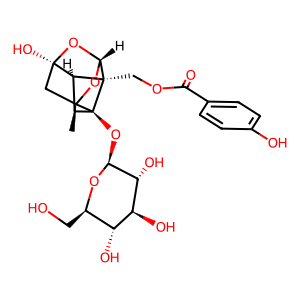

In [23]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import os
sdf_path = "dataset/test/DGSY/sdf"
# 读取 SDF 文件
mols = Chem.SDMolSupplier(os.path.join(sdf_path, '03_Oxypaeoniflorin.sdf'))

# 为每个分子计算二维坐标
for mol in mols:
    if mol is not None:
        tmp = AllChem.Compute2DCoords(mol)

# 绘制并保存第一个分子的图像
img = Draw.MolToImage(mols[0])
img

In [22]:
def get_score(v_d, v_p):
    atom_featurizer = CanonicalAtomFeaturizer()
    bond_featurizer = CanonicalBondFeaturizer(self_loop=True)
    fc = partial(smiles_to_bigraph, add_self_loop=True)
    tokenizer = BertTokenizer.from_pretrained('./prot_bert', do_lower_case=False)
    max_drug_nodes = 290

    v_d = fc(smiles=v_d, node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer)
    v_d = v_d.to(device)
    actual_node_feats = v_d.ndata.pop('h').to(device)
    num_actual_nodes = actual_node_feats.shape[0]
    num_virtual_nodes = max_drug_nodes - num_actual_nodes
    virtual_node_bit = torch.zeros([num_actual_nodes, 1]).to(device)
    actual_node_feats = torch.cat((actual_node_feats, virtual_node_bit), 1).to(device)
    v_d.ndata['h'] = actual_node_feats
    virtual_node_feat = torch.cat(
        (torch.zeros(num_virtual_nodes, 74).to(device), torch.ones(num_virtual_nodes, 1).to(device)), 1)
    v_d.add_nodes(num_virtual_nodes, {"h": virtual_node_feat})
    v_d = v_d.add_self_loop()
    v_d = dgl.batch([v_d])

    # 1. 将序列拆分成单个字符
    sequence_tokens = list(v_p)
    
    # 2. 确保每个字符都在词汇表中
    valid_tokens = []
    for token in sequence_tokens:
        if token in tokenizer.vocab:
            valid_tokens.append(token)
        else:
            valid_tokens.append("[UNK]")
    
    # 3. 重新组合序列
    sequence = " ".join(valid_tokens)
    
    encoding = tokenizer(
        sequence,
        add_special_tokens=True,
        max_length=1024,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # print(f"Sequence length: {len(sequence_tokens)}")
    # print(f"Valid tokens: {len(valid_tokens)}")
    # print(f"First 10 encoded tokens: {encoding['input_ids'][0, :10]}")
    v_p_ids = encoding['input_ids'].to(device)  # 已经有batch维度，shape: [1, seq_len]
    v_p_mask = encoding['attention_mask'].to(device)  # 已经有batch维度，shape: [1, seq_len]
    outputs = model(v_d, v_p_ids, v_p_mask)
    if isinstance(outputs, tuple) and len(outputs) == 4:
        v_d, v_p, f, score = outputs
        score = torch.clamp(score, min=-10, max=10)
    else:
        raise ValueError(f"Expected 4 return values from test_model, got {outputs}")
    # print("origin score:", score)
    res_score = nn.Sigmoid()(score)
    return res_score.cpu().item()
    

In [ ]:
with torch.no_grad():
    model.eval()
    test_path = "dataset/test/DGSY"
    dataset_folder_path = "csv"
    output_path = "output"
    files_in_dataset_folder = os.listdir(os.path.join(test_path, dataset_folder_path))
    count = 1
    for file in files_in_dataset_folder:
        file_path = os.path.join(test_path, dataset_folder_path, file)
        file_out_path = os.path.join(test_path, output_path, file)
        data_list = pd.read_csv(file_path)
        smiles_list = data_list.iloc[:,0]
        sequences_list = data_list.iloc[:,1]
        res_score = []
        res_smile = []
        res_seq = []

        for i in tqdm(range(len(data_list))):
            score = get_score(smiles_list[i], sequences_list[i])
            # print("score: ", score)
            res_score.append(float(score)) 
            res_smile.append(smiles_list[i])
            res_seq.append(sequences_list[i])
        
        result = pd.DataFrame({"smiles": res_smile, "sequence": res_seq, "score": res_score})
        result.to_csv(file_out_path, index=False)
        print(f'{count} completed, {len(files_in_dataset_folder) - count} remains')
        count = count + 1



In [27]:
result_dir = 'dataset/test/DGSY/output'
top_dir_90 = 'output\Top0.9'
result_list = os.listdir(result_dir)
for result in result_list:
    df = pd.read_csv(os.path.join(result_dir, result))
    df_sorted = df[df['score'] > 0.90]
    df_sorted = df_sorted.sort_values(by="score", ascending=False)
    if not os.path.exists(top_dir_90):
        os.mkdir(top_dir_90)
    df_sorted.to_csv(os.path.join(top_dir_90, result), index=False)